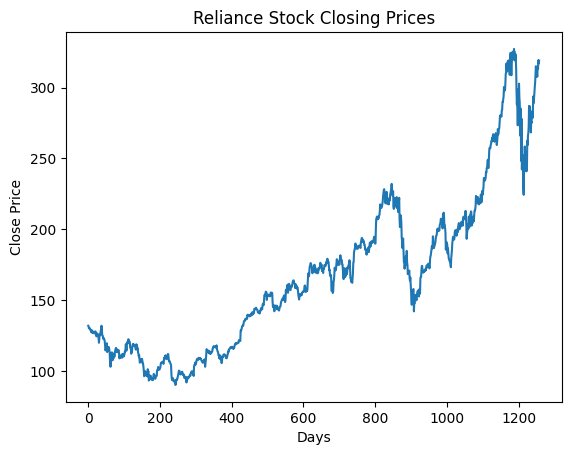

Epoch 1/100
14/14 [==============================] - 9s 181ms/step - loss: 0.0126 - val_loss: 0.0478
Epoch 2/100
14/14 [==============================] - 2s 120ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 3/100
14/14 [==============================] - 2s 117ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 4/100
14/14 [==============================] - 2s 158ms/step - loss: 7.6734e-04 - val_loss: 0.0046
Epoch 5/100
14/14 [==============================] - 2s 169ms/step - loss: 6.4638e-04 - val_loss: 0.0046
Epoch 6/100
14/14 [==============================] - 2s 117ms/step - loss: 6.2928e-04 - val_loss: 0.0053
Epoch 7/100
14/14 [==============================] - 2s 115ms/step - loss: 6.2795e-04 - val_loss: 0.0053
Epoch 8/100
14/14 [==============================] - 2s 117ms/step - loss: 5.9018e-04 - val_loss: 0.0050
Epoch 9/100
14/14 [==============================] - 2s 112ms/step - loss: 5.4633e-04 - val_loss: 0.0046
Epoch 10/100
14/14 [==============================] - 2s 125ms/step

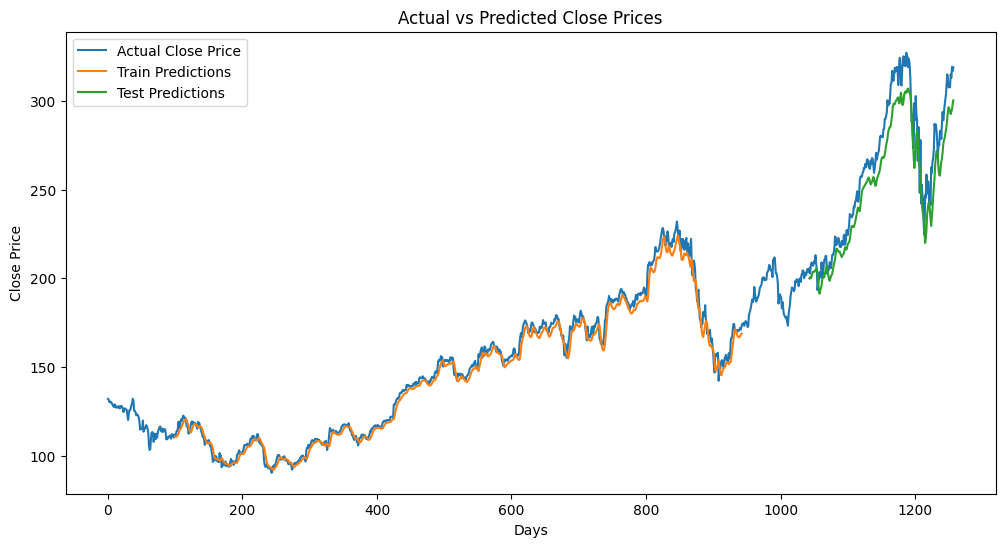

Combined Model RMSE: 2.4580587258265627
Combined Model MAE: 1.1054168151855435
Combined Model R²: 0.996197168623905


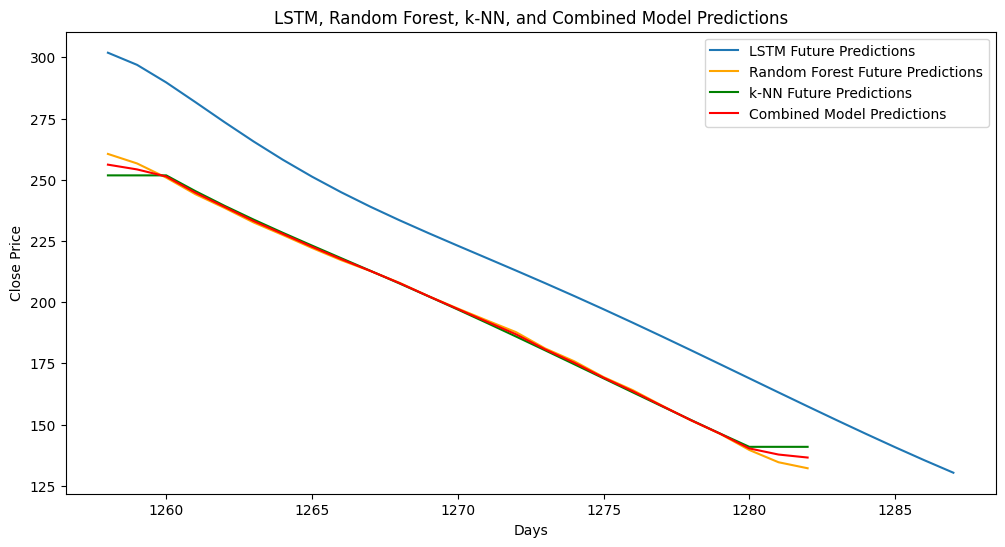

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load and preprocess the data
df = pd.read_csv('Reliance_Stock.csv')

# Remove rows containing NaN values
df = df.dropna()

# Extract the 'Close' column for the target variable
df_close = df['Close']

# Plot the original close prices
plt.plot(df_close)
plt.title('Reliance Stock Closing Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.show()

# Scale the close prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_close_scaled = scaler.fit_transform(np.array(df_close).reshape(-1, 1))

# Split the data into training and testing sets
training_size = int(len(df_close_scaled) * 0.75)
train_data = df_close_scaled[:training_size]
test_data = df_close_scaled[training_size:]

# Create dataset for LSTM model
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - time_step):
        x_seq = dataset[i:(i + time_step)]
        data_x.append(x_seq)
        data_y.append(dataset[i + time_step])
    return np.array(data_x), np.array(data_y)

# Define the time step for sequence data
time_step = 100

# Create training and testing datasets
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape the input data to be in [samples, time steps, features] format
x_train = x_train.reshape(x_train.shape[0], time_step, 1)
x_test = x_test.reshape(x_test.shape[0], time_step, 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

# Predict on training and testing data using LSTM model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform predictions and actual data for better interpretation
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, and R² for training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))

train_mae = mean_absolute_error(y_train_inv, train_predict)
test_mae = mean_absolute_error(y_test_inv, test_predict)

train_r2 = r2_score(y_train_inv, train_predict)
test_r2 = r2_score(y_test_inv, test_predict)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

# Plotting predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df_close_scaled), label='Actual Close Price')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Train Predictions')
plt.plot(np.arange(len(df_close_scaled) - len(test_predict), len(df_close_scaled)), test_predict, label='Test Predictions')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Future prediction for the next 30 days
future_steps = 30
future_predictions = []

# Initialize the input sequence for prediction with the last 100 time steps of the test data
last_input_sequence = list(test_data[-time_step:].flatten())

# Loop to predict the next 30 days using LSTM model
for i in range(future_steps):
    # Reshape input sequence to match LSTM input shape
    input_sequence = np.array(last_input_sequence[-time_step:])
    input_sequence = input_sequence.reshape(1, time_step, 1)

    # Predict the next day's close price
    next_prediction = model.predict(input_sequence, verbose=0)

    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction[0][0])

    # Update the last_input_sequence to include the latest prediction for the next iteration
    last_input_sequence.append(next_prediction[0][0])

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create feature vectors for Random Forest and k-NN using overlapping windows
window_size = 5  # Define the window size (e.g., 5 days)

# Lists to hold feature vectors and targets for Random Forest and k-NN models
x_rf_features = []
y_rf_targets = []

# Create features and targets from LSTM future predictions
for i in range(len(future_predictions) - window_size):
    # Create a feature vector by selecting a window of future predictions
    x_rf_features.append(future_predictions[i:i + window_size].flatten())

    # The target value is the prediction at the end of the window
    y_rf_targets.append(future_predictions[i + window_size])

# Convert lists to NumPy arrays
x_rf_features = np.array(x_rf_features)
y_rf_targets = np.array(y_rf_targets).flatten()  # Flatten targets for consistency

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_rf_features, y_rf_targets)

# Predict future values using the trained Random Forest model
rf_predictions = rf_model.predict(x_rf_features)

# Create and train the k-NN model
k = 5  # Set the number of neighbors for k-NN
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(x_rf_features, y_rf_targets)

# Predict future values using the trained k-NN model
knn_predictions = knn_model.predict(x_rf_features)

# Combine Random Forest and k-NN predictions
combined_predictions = (rf_predictions + knn_predictions) / 2

# Ensure combined predictions are in a one-dimensional array
combined_predictions = combined_predictions.flatten()

# Calculate RMSE, MAE, and R² for the combined model
combined_rmse = np.sqrt(mean_squared_error(y_rf_targets, combined_predictions))
combined_mae = mean_absolute_error(y_rf_targets, combined_predictions)
combined_r2 = r2_score(y_rf_targets, combined_predictions)

print(f"Combined Model RMSE: {combined_rmse}")
print(f"Combined Model MAE: {combined_mae}")
print(f"Combined Model R²: {combined_r2}")

# Plot future predictions from LSTM, Random Forest, and k-NN models
plt.figure(figsize=(12, 6))
# Plot LSTM future predictions
plt.plot(np.arange(len(df_close_scaled), len(df_close_scaled) + future_steps), future_predictions, label='LSTM Future Predictions')
# Plot Random Forest future predictions
plt.plot(np.arange(len(df_close_scaled), len(df_close_scaled) + future_steps - window_size), rf_predictions, label='Random Forest Future Predictions', color='orange')
# Plot k-NN future predictions
plt.plot(np.arange(len(df_close_scaled), len(df_close_scaled) + future_steps - window_size), knn_predictions, label='k-NN Future Predictions', color='green')
# Plot combined model predictions
plt.plot(np.arange(len(df_close_scaled), len(df_close_scaled) + future_steps - window_size), combined_predictions, label='Combined Model Predictions', color='red')
plt.title('LSTM, Random Forest, k-NN, and Combined Model Predictions')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    """
    Calculate the accuracy of regression predictions.

    Args:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.
        tolerance (float): Allowed deviation from actual values for predictions to be considered accurate.
                           Default is 0.05 (5% tolerance).

    Returns:
        float: Accuracy as the percentage of predictions within the tolerance range.
    """
    # Calculate absolute error as the absolute difference between true and predicted values
    absolute_error = np.abs(y_true - y_pred)

    # Calculate tolerance range based on the tolerance percentage
    tolerance_range = tolerance * y_true

    # Determine whether each prediction is within the tolerance range
    within_tolerance = absolute_error <= tolerance_range

    # Calculate accuracy as the percentage of predictions within the tolerance range
    accuracy = np.mean(within_tolerance) * 100

    return accuracy

# Calculate accuracy for the training and testing datasets
train_accuracy = calculate_accuracy(y_train_inv, train_predict)
test_accuracy = calculate_accuracy(y_test_inv, test_predict)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train Accuracy: 94.54%
Test Accuracy: 61.40%
